# Train linear classifier

I choose linear classifier to make a baseline. For practice, I use 2 versions:
1. built from scratch linear classifier (written during passing cs231n assignment) with softmax
2. Logistic Regression (written as subclass of pytorch nn.Module) with sigmoid

Both of them used Cross-Entropy loss (`nn.BCELoss()` for the second case).

## Required imports

In [37]:
import math
import pickle
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from config import path_to_mean_image
from modules.load_data import load_data
from modules.train_functions import check_accuracy, plot_accs_and_loss, train_nn, cross_validation_score

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

path_to_root = '../'
path_to_mean_image = path_to_root + path_to_mean_image

## Load images and apply transformations

In [9]:
spatial_shape = 64
height, width = 84, 64

train_transforms = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((height, width)),
    transforms.ColorJitter(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((height, width)),
    transforms.ColorJitter(),
    transforms.ToTensor(),
])


X_train, y_train = load_data(path_to_root + 'train_data', train_transforms, path_to_mean_image)
X_val, y_val = load_data(path_to_root + 'val_data', train_transforms, path_to_mean_image)
X_hold, y_hold = load_data(path_to_root + 'hold_data', test_transforms, path_to_mean_image)

print(f'X_train has {X_train.shape[0]} samples')
print(f'X_val has {X_val.shape[0]} samples')
print(f'X_hold has {X_hold.shape[0]} samples')

X_train has 15000 samples
X_val has 3000 samples
X_hold has 10000 samples


In [27]:
X_train = X_train.view(X_train.shape[0], -1)
X_val = X_val.view(X_val.shape[0], -1)
X_hold = X_hold.view(X_hold.shape[0], -1)

## Linear classifier built from scratch

I take away all code from cs231n assignment that used in linear classifier in single module.

In [25]:
from modules.linear_classifier_cs231n import Softmax

Search best set of hyperparameters: learning rate and regularization strengths

In [33]:
best_val = -1
best_softmax = None

learning_rates = [5e-2, 1e-1, 5e-1, 0.5, 1.0]
regularization_strengths = [1e-6, 5e-6, 1e-5]

results = {}

for lr in learning_rates:
    for rg in regularization_strengths:
        model = Softmax()
        model.train(X_train, y_train, lr, rg, batch_size=500, num_iters=300)
        y_pred_train = model.predict(X_train)
        y_pred_val = model.predict(X_val)
        tr_acc = (y_pred_train == y_train).float().mean().item()
        val_acc = (y_pred_val == y_val).float().mean().item()
        results[(lr, rg)] = (tr_acc, val_acc)
        if val_acc > best_val:
            best_val = val_acc
            best_softmax = model
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 5.000000e-02 reg 1.000000e-06 train accuracy: 0.781000 val accuracy: 0.803333
lr 5.000000e-02 reg 5.000000e-06 train accuracy: 0.781400 val accuracy: 0.800667
lr 5.000000e-02 reg 1.000000e-05 train accuracy: 0.784133 val accuracy: 0.799667
lr 1.000000e-01 reg 1.000000e-06 train accuracy: 0.769733 val accuracy: 0.783667
lr 1.000000e-01 reg 5.000000e-06 train accuracy: 0.777200 val accuracy: 0.795333
lr 1.000000e-01 reg 1.000000e-05 train accuracy: 0.772467 val accuracy: 0.791333
lr 5.000000e-01 reg 1.000000e-06 train accuracy: 0.669600 val accuracy: 0.672000
lr 5.000000e-01 reg 5.000000e-06 train accuracy: 0.625600 val accuracy: 0.623000
lr 5.000000e-01 reg 1.000000e-05 train accuracy: 0.659533 val accuracy: 0.662667
lr 1.000000e+00 reg 1.000000e-06 train accuracy: 0.684267 val accuracy: 0.692667
lr 1.000000e+00 reg 5.000000e-06 train accuracy: 0.704067 val accuracy: 0.710667
lr 1.000000e+00 reg 1.000000e-05 train accuracy: 0.649933 val accuracy: 0.654667
best validation accuracy ach

### Test it on a hold (unseen) data

In [34]:
y_pred_hold = best_softmax.predict(X_hold)
(y_pred_hold == y_hold).float().mean().item()

0.7774999737739563

## Move from the handmade version to the PyTorch's `nn.Module`

Also it is time to change Softmax to Sigmoid function

In [14]:
class LogisticRegression(nn.Module):
  
    def __init__(self, height=84, width=64):
        super(LogisticRegression, self).__init__()
        self.fc = nn.Linear(height * width, 1)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        out = self.fc(x)
        out = torch.sigmoid(out)
        return out

In [15]:
logreg = LogisticRegression()
if torch.cuda.is_available():
    print('Cuda available')
    logreg = logreg.cuda()

criterion = nn.BCELoss()
optimizer = optim.Adam(logreg.parameters(), lr=1e-3, betas=(0.9, 0.999), weight_decay=0.1)

train_parameters = {
    'model': logreg,
    'criterion': criterion,
    'optimizer': optimizer
}

Fold 1 ->
Start training
Epoch [1/20] it 50: loss 0.5494681638479233 - train acc 0.7555000185966492 - val acc 0.754800021648407
Epoch [2/20] it 50: loss 0.49937386155128477 - train acc 0.7663000226020813 - val acc 0.7666000127792358
Epoch [3/20] it 50: loss 0.48160898983478545 - train acc 0.7764000296592712 - val acc 0.777400016784668
Epoch [4/20] it 50: loss 0.4770610290765762 - train acc 0.7771000266075134 - val acc 0.7796000242233276
Epoch [5/20] it 50: loss 0.4676227033138275 - train acc 0.7809000015258789 - val acc 0.7789999842643738
Epoch [6/20] it 50: loss 0.4593894773721695 - train acc 0.7827000021934509 - val acc 0.7789999842643738
Epoch [7/20] it 50: loss 0.44920807719230654 - train acc 0.7835999727249146 - val acc 0.782800018787384
Epoch [8/20] it 50: loss 0.456394362449646 - train acc 0.7821000218391418 - val acc 0.771399974822998
Epoch [9/20] it 50: loss 0.4698195707798004 - train acc 0.7893000245094299 - val acc 0.7871999740600586
Epoch [10/20] it 50: loss 0.4584858411550

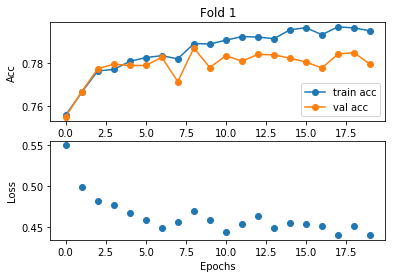

Fold 2 ->
Start training
Epoch [1/20] it 50: loss 0.5395327645540238 - train acc 0.760699987411499 - val acc 0.7585999965667725
Epoch [2/20] it 50: loss 0.4869392764568329 - train acc 0.7799000144004822 - val acc 0.7621999979019165
Epoch [3/20] it 50: loss 0.4784341925382614 - train acc 0.7763000130653381 - val acc 0.7635999917984009
Epoch [4/20] it 50: loss 0.4639934438467026 - train acc 0.7883999943733215 - val acc 0.7721999883651733
Epoch [5/20] it 50: loss 0.4616652888059616 - train acc 0.7922000288963318 - val acc 0.774399995803833
Epoch [6/20] it 50: loss 0.4616216844320297 - train acc 0.7964000105857849 - val acc 0.7771999835968018
Epoch [7/20] it 50: loss 0.44729249238967894 - train acc 0.7958999872207642 - val acc 0.771399974822998
Epoch [8/20] it 50: loss 0.4557919859886169 - train acc 0.7968000173568726 - val acc 0.7753999829292297
Epoch [9/20] it 50: loss 0.45204382836818696 - train acc 0.7950999736785889 - val acc 0.7734000086784363
Epoch [10/20] it 50: loss 0.438644015192

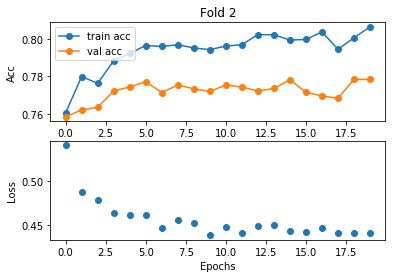

Fold 3 ->
Start training
Epoch [1/20] it 50: loss 0.5485216999053955 - train acc 0.7612000107765198 - val acc 0.7581999897956848
Epoch [2/20] it 50: loss 0.4944247442483902 - train acc 0.7718999981880188 - val acc 0.7699999809265137
Epoch [3/20] it 50: loss 0.4752731287479401 - train acc 0.7791000008583069 - val acc 0.7735999822616577
Epoch [4/20] it 50: loss 0.4683589905500412 - train acc 0.7809000015258789 - val acc 0.7734000086784363
Epoch [5/20] it 50: loss 0.4668304944038391 - train acc 0.7843000292778015 - val acc 0.7775999903678894
Epoch [6/20] it 50: loss 0.47259469926357267 - train acc 0.7771000266075134 - val acc 0.7706000208854675
Epoch [7/20] it 50: loss 0.47059674680233 - train acc 0.7882999777793884 - val acc 0.774399995803833
Epoch [8/20] it 50: loss 0.46441889584064483 - train acc 0.7889999747276306 - val acc 0.7778000235557556
Epoch [9/20] it 50: loss 0.46079103350639344 - train acc 0.792900025844574 - val acc 0.7753999829292297
Epoch [10/20] it 50: loss 0.452394643425

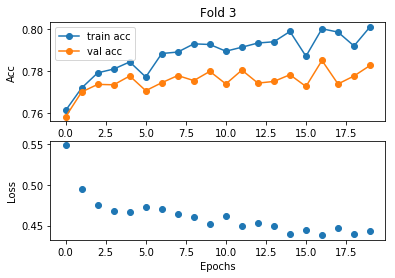

CPU times: user 25.5 s, sys: 1.02 s, total: 26.6 s
Wall time: 6.73 s


In [16]:
%%time
torch.manual_seed(777)

val_results = cross_validation_score(LogisticRegression, X_train, y_train, num_folds=3, num_epochs=20)

In [17]:
print(val_results)
print(np.mean(val_results))
print(np.std(val_results))

[0.7871999740600586, 0.7784000039100647, 0.7850000262260437]
0.7835333347320557
0.003739274137592174


## Create and train model with selected hyperparameters

In [18]:
net = LogisticRegression()
if torch.cuda.is_available():
    net = net.cuda()

criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3, betas=(0.9, 0.999))

train_parameters = {
    'model': net,
    'criterion': criterion,
    'optimizer': optimizer
}

In [19]:
%%time
torch.manual_seed(777)

results, best_val = train_nn(train_parameters, X_train, y_train, X_val, y_val, 
                             num_epochs=50, checkpoint_filename=path_to_root + 'models/logreg.pth')

Start training
Epoch [1/50] it 300: loss 0.4978844208518664 - train acc 0.7693333625793457 - val acc 0.7960000038146973
Epoch [2/50] it 300: loss 0.4795732113718987 - train acc 0.7844666838645935 - val acc 0.8046666383743286
Epoch [3/50] it 300: loss 0.47039469530185063 - train acc 0.7844666838645935 - val acc 0.7963333129882812
Epoch [4/50] it 300: loss 0.46105368196964264 - train acc 0.7876666784286499 - val acc 0.8036666512489319
Epoch [5/50] it 300: loss 0.4592744713028272 - train acc 0.7829333543777466 - val acc 0.7996666431427002
Epoch [6/50] it 300: loss 0.45430411502718926 - train acc 0.791866660118103 - val acc 0.8086666464805603
Epoch [7/50] it 300: loss 0.4603512633840243 - train acc 0.7910666465759277 - val acc 0.8090000152587891
Epoch [8/50] it 300: loss 0.4455921114484469 - train acc 0.7946666479110718 - val acc 0.8053333163261414
Epoch [9/50] it 300: loss 0.45194798757632576 - train acc 0.8005333542823792 - val acc 0.8083333373069763
Epoch [10/50] it 300: loss 0.44883459

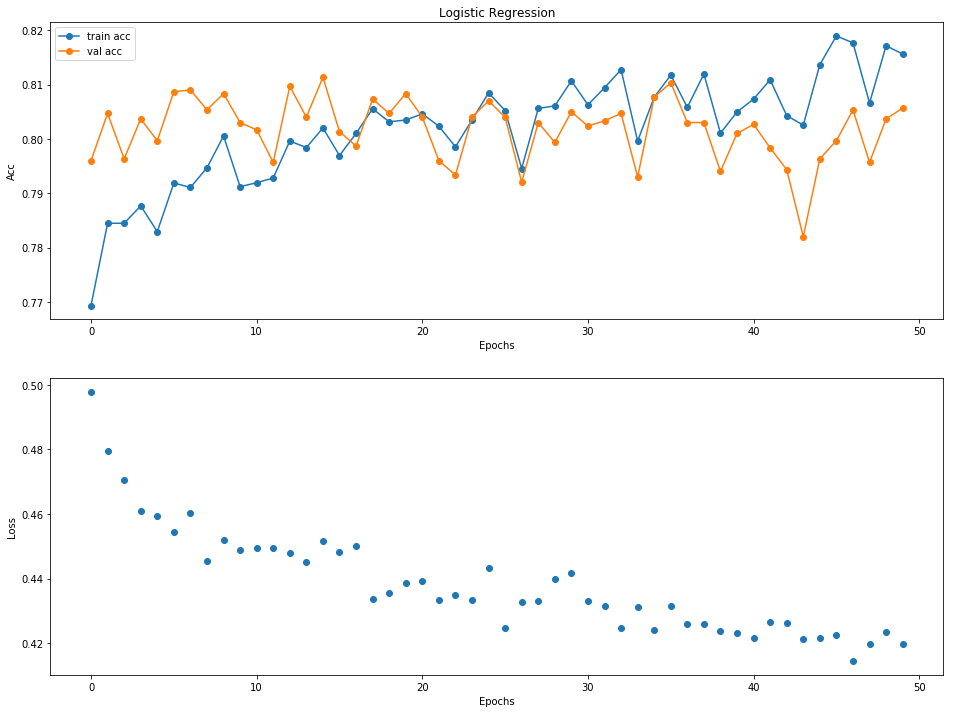

In [22]:
plot_accs_and_loss(results, 'Logistic Regression')

In [35]:
best_logreg = LogisticRegression()
best_logreg.load_state_dict(torch.load(path_to_root + 'models/logreg.pth'))

<All keys matched successfully>

In [36]:
%%time
check_accuracy(best_logreg, X_hold, y_hold)

CPU times: user 48.3 ms, sys: 2.51 ms, total: 50.8 ms
Wall time: 12.3 ms


0.784600019454956

## Conclusion:

1. Built from scratch classifier achieved accuracy `0.8033` during cross-validation and `0.7775` on the hold data
2. Logistic Regression created with PyTorch reached `0.7835` during cross-validation and `0.7846` on the hold data

Handwritten linear classifier always has 1 training epoch when created with PyTorch has 50 epochs.